## Import

In [13]:
import numpy as np
#from scipy import stats
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.image as mpimg

import torch 
from torch import distributions
from torch import nn
from torch.utils import data

In [14]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

## functions

In [15]:
def prepare_image_filter(rgb, crop=None, embed=None, white_cutoff=255, gauss_sigma=3, background=0.01):
    """ Transforms rgb image array into 2D-density and energy
    Parameters
    ----------
    density : ndarray(width, height)
        Probability density
    energy : ndarray(width, height)
        Energy
    """
    img = rgb

    # make one channel
    img = img.mean(axis=2)

    # make background white
    img = img.astype(np.float32)
    img[img > white_cutoff] = 255

    # normalize
    img /= img.max()

    if crop is not None:
        # crop
        img = img[crop[0]:crop[1], crop[2]:crop[3]]

#    if embed is not None:
#        tmp = np.ones((embed[0], embed[1]), dtype=np.float32)
#        shift_x = (embed[0] - img.shape[0]) // 2
#        shift_y = (embed[1] - img.shape[1]) // 2
#        tmp[shift_x:img.shape[0]+shift_x, shift_y:img.shape[1]+shift_y] = img
#        img = tmp

    # convolve with Gaussian
    from scipy.ndimage import gaussian_filter
    img2 = gaussian_filter(img, sigma=gauss_sigma)

    # add background
    background1 = gaussian_filter(img, sigma=10)
    background2 = gaussian_filter(img, sigma=20)
    background3 = gaussian_filter(img, sigma=50)
    density = (1.0-img2) + background * (background1 + background2 + background3)
#    density=1.0-img2

    U = -np.log(density)
    U -= U.min()

    return density, U

In [16]:
def ImageSampler(img_density, mean, scale, n_sample=10000):
  Ix, Iy = np.meshgrid(np.arange(img_density.shape[1]), np.arange(img_density.shape[0]))
  idx = np.vstack([Ix.flatten(), Iy.flatten()]).T
  density_normed = img_density.astype(np.float64)
  density_normed /= density_normed.sum()
  density_flat = density_normed.flatten()
  mean = np.array([mean])
  scale = np.array([scale])
  i = np.random.choice(idx.shape[0], size=n_sample, p=density_flat)
  ixy = idx[i, :]
  xy = ixy + np.random.rand(n_sample, 2) - 0.5
#  xy=ixy
  xy = (xy - mean) / scale
  return xy

## Model


In [17]:
def image_target_energy(X, pixel_energy, mean=[350,350],scale=[100,100],outside_penalty=2.0):
  X=torch.tensor(X)
  maxindex_x=torch.tensor([pixel_energy.shape[1] - 1])
  maxindex_y=torch.tensor([pixel_energy.shape[0] - 1])
  Xs = X * scale.to(dtype=torch.float32) + mean.to(dtype=torch.float32)
  I = Xs.to(dtype=torch.long)
  Ix = I[:, 0]
  Iy = I[:, 1]
  dx = Xs[:, 0] - Ix.to(dtype=torch.float32)
  dy = Xs[:, 1] - Iy.to(dtype=torch.float32)
  zero = torch.tensor([0])
  Ix_inside = torch.max(torch.min(Ix, maxindex_x-1), zero+1)
  Iy_inside = torch.max(torch.min(Iy, maxindex_y-1), zero+1)
  E0 = pixel_energy[Iy_inside, Ix_inside]
  dEdx = 0.5 * (pixel_energy[Iy_inside, Ix_inside+1] - pixel_energy[Iy_inside, Ix_inside-1])
  dEdy = 0.5 * (pixel_energy[Iy_inside+1, Ix_inside] - pixel_energy[Iy_inside-1, Ix_inside])
  image_energy = E0 + dx * dEdx + dy * dEdy
  image_energy = image_energy.unsqueeze(-1)
  dx_left  = torch.max(-Ix, zero)
  dx_right = torch.max(Ix - maxindex_x, zero)
  dx = torch.max(dx_left, dx_right)
  dy_down  = torch.max(-Iy, zero)
  dy_up    = torch.max(Iy - maxindex_y, zero)
  dy = torch.max(dy_down, dy_up)
  penalty = outside_penalty * (dx**2 + dy**2).to(dtype=torch.float32)
  penalty = penalty.unsqueeze(-1)
  return image_energy + penalty

In [18]:
class Image_RealNVP_stochastic(nn.Module):
  def __init__(self,stochastic=False,step_size=0.25,nsteps=10,n_hidden=256,prior=None,n_block=5,masks=None,nets=None,nett=None,
               target=True,pixel_energy=None,mean=[350,350],scale=[100,100]):
    super(Image_RealNVP_stochastic,self).__init__()
    self.stochastic=stochastic
    self.step_size=step_size
    self.nsteps=nsteps
    self.target=target

    if nets==None:
      nets = lambda: nn.Sequential(nn.Linear(2, self.n_hidden), nn.ReLU(), nn.Linear(self.n_hidden, self.n_hidden), nn.ReLU(), nn.Linear(self.n_hidden, 2), nn.Tanh())
    if nett==None:
      nett = lambda: nn.Sequential(nn.Linear(2, self.n_hidden), nn.ReLU(), nn.Linear(self.n_hidden, self.n_hidden), nn.ReLU(), nn.Linear(self.n_hidden, 2))

    if prior==None:
      self.prior = distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))

    self.n_hidden=n_hidden
    self.n_block=n_block
    if masks==None:
      self.masks = nn.Parameter(torch.from_numpy(np.array([[0, 1], [1, 0]] * self.n_block).astype(np.float32)), requires_grad=False)

    self.nett = torch.nn.ModuleList([nett() for _ in range(len(self.masks))]) # translation
    self.nets = torch.nn.ModuleList([nets() for _ in range(len(self.masks))]) # scaling 

    self.pixel_energy = torch.tensor(pixel_energy)
    self.mean = torch.tensor([mean])
    self.scale = torch.tensor([scale])


  def target_energy(self,x):
#    target=self.target
    if self.target==None:
      return self.prior_energy(x)
    else:
      return image_target_energy(x,pixel_energy=self.pixel_energy,mean=self.mean,scale=self.scale)

  def prior_energy(self, z):
    return 0.5*torch.linalg.norm(z,dim=1)**2

  def MCMC_forward(self, x ):
    stepsize=self.step_size
    nsteps=self.nsteps
    E0 = self.target_energy(x).reshape((x.shape[0],1))
    Et = E0
    for i in range(nsteps):
        # proposal step
        dx = stepsize * torch.zeros_like(x).normal_()
        xprop = x + dx
        Eprop = self.target_energy(xprop).reshape((x.shape[0],1))
        # acceptance step
        acc = (torch.rand(x.shape[0],1) < torch.exp(-(Eprop - Et))).float() 
        x = (1-acc) * x + acc * xprop
        Et = (1-acc) * Et + acc * Eprop

    dW = (Et - E0).reshape(x.shape[0],)
    return x, dW

  def MCMC_backward(self, z):
    stepsize=self.step_size
    nsteps=self.nsteps
    E0 = self.prior_energy(z).reshape((z.shape[0],1))
    Et = E0
    for i in range(nsteps):
        # proposal step
        dz = stepsize * torch.zeros_like(z).normal_()
        zprop = z + dz
        Eprop = self.prior_energy(zprop).reshape((z.shape[0],1))
        # acceptance step
        acc = (torch.rand(z.shape[0],1) < torch.exp(-(Eprop - Et))).float()
        z = (1-acc) * z + acc * zprop
        Et = (1-acc) * Et + acc * Eprop

    dW = (Et - E0).reshape(z.shape[0],)
    return z, dW


  def forward_flow(self,z):
    stochastic=self.stochastic
    log_R_zx, x = z.new_zeros(z.shape[0]), z

    for i in range(len(self.masks)):
      x1= x*self.masks[i]

      s=self.nets[i](x1)*(1-self.masks[i])
      t=self.nett[i](x1)*(1-self.masks[i])

      x=x1+(1-self.masks[i])* (x*torch.exp(s)+t)
      log_R_zx+=torch.sum(s,-1)
      if stochastic==True:
        x,dw=self.MCMC_forward(x)
        log_R_zx+=dw
    return x, log_R_zx

  def backward_flow(self,x):
    stochastic=self.stochastic
    log_R_xz, z = x.new_zeros(x.shape[0]), x

    for i in reversed(range(len(self.masks))):
      if stochastic==True:
        z, dw=self.MCMC_backward(z)
        log_R_xz+=dw

      z1= z*self.masks[i]

      s=self.nets[i](z1)*(1-self.masks[i])
      t=self.nett[i](z1)*(1-self.masks[i])

      z=z1+(1-self.masks[i])*(z-t)*torch.exp(-s)
      log_R_xz-=torch.sum(s,-1)

    return z, log_R_xz

  def sample(self, batchSize):
      z = self.prior.sample((batchSize,))
      x, log_R_zx = self.forward_flow(z)
      return z.detach().numpy() , x.detach().numpy(), log_R_zx.detach().numpy()

  def loss(self, batch, w_ml = 1.0, w_kl = 0.0, w_rc = 0.0):
      return w_ml*self.loss_ml(batch) + w_kl*self.loss_kl(batch) + w_rc*self.loss_rc(batch)  

  def loss_ml(self, batch_x):
      z, log_R_xz = self.backward_flow(batch_x)
      energy=0.5*torch.linalg.norm(z,dim=1)**2
      return torch.mean(energy-log_R_xz)

  def loss_kl(self, batch_z):
      x, log_R_zx = self.forward_flow(batch_z)
      energy=self.target_energy(x)
#      e_high=1e4
#      for i in range(len(energy)):
#        if abs(energy[i]) == float('inf'):
#                print("energy overflow detected")
#        elif energy[i] > e_high:
#                energy[i] = e_high + torch.log(energy[i] - e_high + 1.0)
      return torch.mean(energy - log_R_zx)  

## Data

(720, 1280, 3)


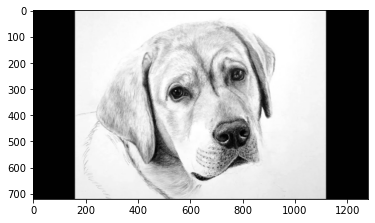

In [19]:
img=mpimg.imread('Image_data\labrador.jpg')
print(img.shape)
plt.imshow(img)

In [20]:
mean = [350, 350]
scale = [100, 100]
#tail = 3.5

In [21]:
img_density, img_energy = prepare_image_filter(img, crop=(10, 710, 240, 940),white_cutoff=255)

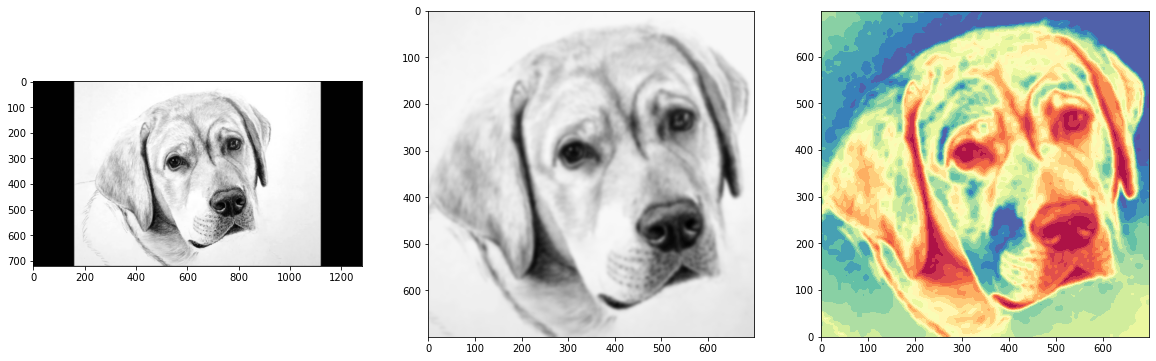

In [22]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(20, 6))
axes[0].imshow(img)
axes[1].imshow(img_density, vmin=0, vmax=1, cmap='gray_r')
axes[2].contourf(img_energy[::-1], 20, vmin=img_energy.min(), vmax=img_energy.max(), cmap='Spectral')

In [23]:
X=ImageSampler(img_density[::-1].copy(),n_sample=50000,mean=mean,scale=scale)

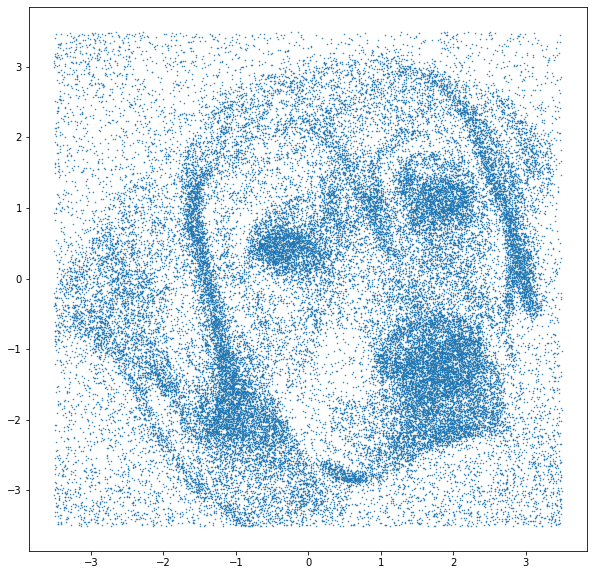

In [24]:
#data = torch.tensor(X, dtype=torch.float32)

plt.figure(figsize=(10, 10))
plt.plot(X[:, 0], X[:, 1], linewidth=0, marker='.', markersize=1)

## BG

In [25]:
model_BG=Image_RealNVP_stochastic(target=True,pixel_energy=img_energy[::-1].copy())

In [26]:
iter1=4000
iter2=4000
lr1=0.0001
lr2=0.0001
batch_size1=1000
batch_size2=1000

In [27]:
training_data=X
np.random.shuffle(training_data)
training_data.shape

(50000, 2)

In [28]:
optimizer = torch.optim.Adam(model_BG.parameters(), lr=lr1) 

training_data = training_data.astype('float32')

trainloader = data.DataLoader(dataset=training_data, batch_size=batch_size1)

losses = [] 

In [29]:
t = 0 
while t < iter1:
    for batch in trainloader:  
        
        # Custom ML loss function
        loss = model_BG.loss_ml(batch) 
        losses.append(loss.item()) # save values for plotting later 
    
        # Training
        optimizer.zero_grad() # Set grads to zero
        loss.backward(retain_graph=True)
        optimizer.step()
        
        t = t + 1 # iteration count
        if t % 25 == 0:
            print('iter %s:' % t, 'loss = %.3f' % loss)

iter 25: loss = 2.087
iter 50: loss = 2.003
iter 75: loss = 1.927
iter 100: loss = 1.896
iter 125: loss = 1.891
iter 150: loss = 1.875
iter 175: loss = 1.876
iter 200: loss = 1.864
iter 225: loss = 1.865
iter 250: loss = 1.854
iter 275: loss = 1.858
iter 300: loss = 1.844
iter 325: loss = 1.851
iter 350: loss = 1.833
iter 375: loss = 1.845
iter 400: loss = 1.827
iter 425: loss = 1.842
iter 450: loss = 1.818
iter 475: loss = 1.835
iter 500: loss = 1.812
iter 525: loss = 1.830
iter 550: loss = 1.808
iter 575: loss = 1.826
iter 600: loss = 1.806
iter 625: loss = 1.823
iter 650: loss = 1.804
iter 675: loss = 1.821
iter 700: loss = 1.799
iter 725: loss = 1.814
iter 750: loss = 1.797
iter 775: loss = 1.810
iter 800: loss = 1.793
iter 825: loss = 1.809
iter 850: loss = 1.789
iter 875: loss = 1.804
iter 900: loss = 1.785
iter 925: loss = 1.804
iter 950: loss = 1.782
iter 975: loss = 1.810
iter 1000: loss = 1.782
iter 1025: loss = 1.801
iter 1050: loss = 1.779
iter 1075: loss = 1.799
iter 1100:

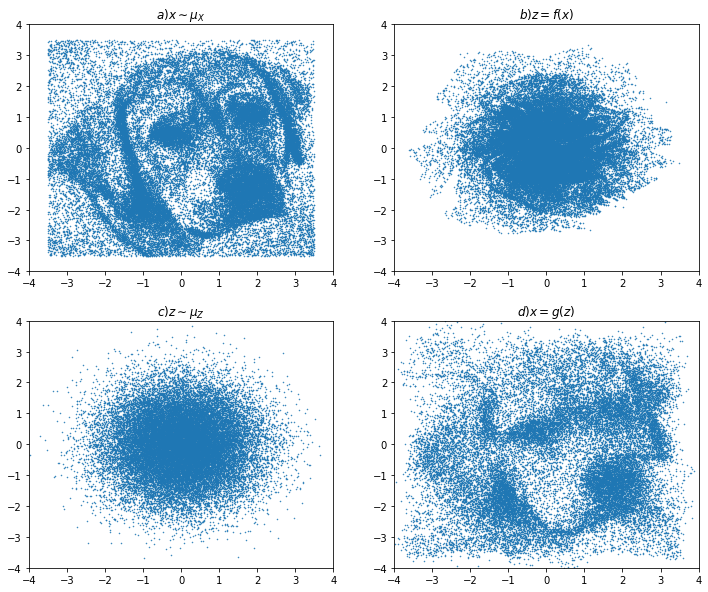

In [30]:
# Visualize the learned transformation (After training)
fig, axes = plt.subplots(2, 2, figsize = (12,10))

# plot data sampled in real space 
plt.subplot(221)
plt.plot(X[:, 0], X[:, 1], linewidth=0, marker='.', markersize=1)
#ax=plt.gca()
#ax.hist2d(X[:,0],X[:,1],bins=100,norm=matplotlib.colors.LogNorm())
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.title(r'$a) x \sim \mu_X$')

# sample from x and transform to z 
zb=model_BG.backward_flow(torch.from_numpy(training_data))[0].detach().numpy()
plt.subplot(222)
plt.plot(zb[:, 0], zb[:, 1], linewidth=0, marker='.', markersize=1)
# ax=plt.gca()
# ax.hist2d(zb[:,0],zb[:,1],bins=100,norm=matplotlib.colors.LogNorm())
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.title(r'$b) z = f(x)$')

# sampling from the multivariate gaussian with zero mean and unit variance
z, x, _ = model_BG.sample(30000)
plt.subplot(223)
plt.plot(z[:, 0], z[:, 1], linewidth=0, marker='.', markersize=1)
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.title(r'$c) z \sim \mu_Z$')

# sample 10000 points from prior and transform to target
plt.subplot(224)
plt.plot(x[:, 0], x[:, 1], linewidth=0, marker='.', markersize=1)
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.title(r'$d) x = g(z)$')

plt.show()

#plot_energy(x[:,0]) #plot energy

(-4.0, 4.0)

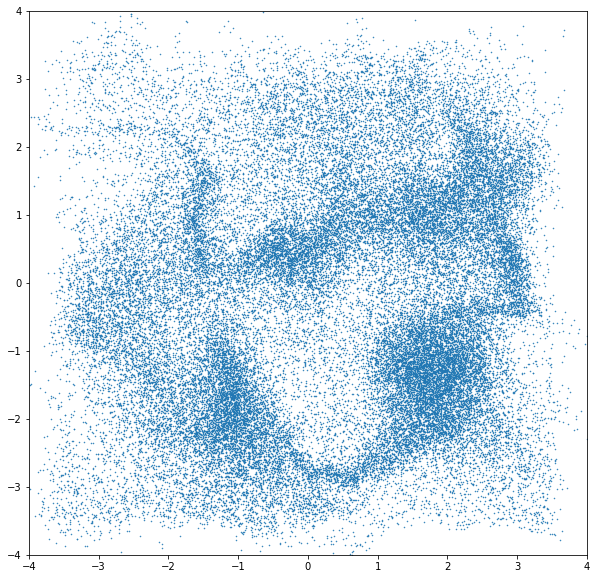

In [31]:
z, x, _ = model_BG.sample(50000)
plt.figure(figsize=(10, 10))
plt.plot(x[:, 0], x[:, 1], linewidth=0, marker='.', markersize=1)
plt.xlim(-4, 4)
plt.ylim(-4, 4)

## SNF

In [32]:
model_SNF=Image_RealNVP_stochastic(target=True,pixel_energy=img_energy[::-1].copy(),stochastic=True,step_size=0.25,nsteps=10)

In [33]:
iter1=4000
iter2=4000
lr1=0.0001
lr2=0.0001
batch_size1=1000
batch_size2=1000

In [34]:
training_data=X
np.random.shuffle(training_data)
training_data.shape

(50000, 2)

In [35]:
optimizer = torch.optim.Adam(model_SNF.parameters(), lr=lr1) 

training_data = training_data.astype('float32')

trainloader = data.DataLoader(dataset=training_data, batch_size=batch_size1)

losses = [] 

In [36]:
t = 0 
while t < iter1:
    for batch in trainloader:  
        
        # Custom ML loss function
        loss = model_SNF.loss_ml(batch) 
        losses.append(loss.item()) # save values for plotting later 
    
        # Training
        optimizer.zero_grad() # Set grads to zero
        loss.backward(retain_graph=True)
        optimizer.step()
        
        t = t + 1 # iteration count
        if t % 25 == 0:
            print('iter %s:' % t, 'loss = %.3f' % loss)

iter 25: loss = 2.726
iter 50: loss = 2.695
iter 75: loss = 2.677
iter 100: loss = 2.669
iter 125: loss = 2.688
iter 150: loss = 2.711
iter 175: loss = 2.679
iter 200: loss = 2.692
iter 225: loss = 2.660
iter 250: loss = 2.701
iter 275: loss = 2.689
iter 300: loss = 2.695
iter 325: loss = 2.692
iter 350: loss = 2.617
iter 375: loss = 2.653
iter 400: loss = 2.686
iter 425: loss = 2.728
iter 450: loss = 2.698
iter 475: loss = 2.719
iter 500: loss = 2.635
iter 525: loss = 2.646
iter 550: loss = 2.655
iter 575: loss = 2.733
iter 600: loss = 2.680
iter 625: loss = 2.744
iter 650: loss = 2.665
iter 675: loss = 2.732
iter 700: loss = 2.671
iter 725: loss = 2.694
iter 750: loss = 2.671
iter 775: loss = 2.692
iter 800: loss = 2.676
iter 825: loss = 2.676
iter 850: loss = 2.699
iter 875: loss = 2.755
iter 900: loss = 2.706
iter 925: loss = 2.706
iter 950: loss = 2.667
iter 975: loss = 2.698
iter 1000: loss = 2.660
iter 1025: loss = 2.708
iter 1050: loss = 2.655
iter 1075: loss = 2.692
iter 1100:

D:\language_lib\Pythons\anaconda3\envs\SNF\lib\site-packages\ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


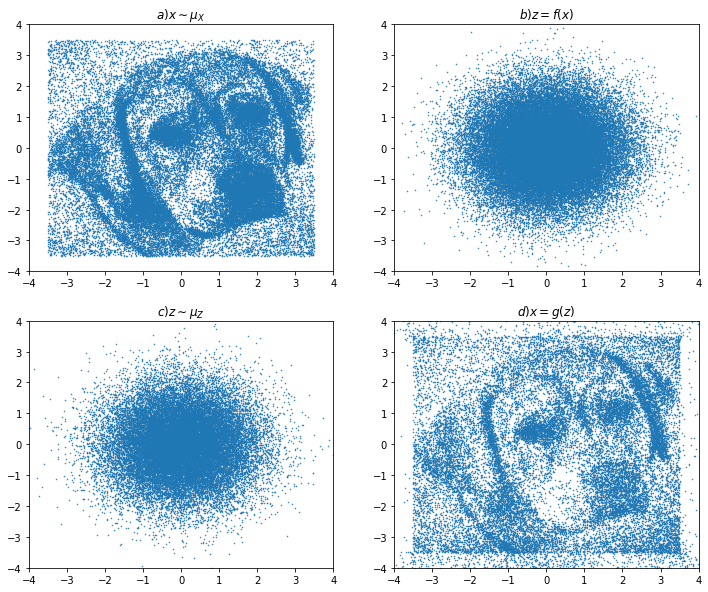

In [37]:
# Visualize the learned transformation (After training)
fig, axes = plt.subplots(2, 2, figsize = (12,10))

# plot data sampled in real space 
plt.subplot(221)
plt.plot(X[:, 0], X[:, 1], linewidth=0, marker='.', markersize=1)
#ax=plt.gca()
#ax.hist2d(X[:,0],X[:,1],bins=100,norm=matplotlib.colors.LogNorm())
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.title(r'$a) x \sim \mu_X$')

# sample from x and transform to z 
zb=model_SNF.backward_flow(torch.from_numpy(training_data))[0].detach().numpy()
plt.subplot(222)
plt.plot(zb[:, 0], zb[:, 1], linewidth=0, marker='.', markersize=1)
# ax=plt.gca()
# ax.hist2d(zb[:,0],zb[:,1],bins=100,norm=matplotlib.colors.LogNorm())
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.title(r'$b) z = f(x)$')

# sampling from the multivariate gaussian with zero mean and unit variance
z, x, _ = model_SNF.sample(30000)
plt.subplot(223)
plt.plot(z[:, 0], z[:, 1], linewidth=0, marker='.', markersize=1)
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.title(r'$c) z \sim \mu_Z$')

# sample 10000 points from prior and transform to target
plt.subplot(224)
plt.plot(x[:, 0], x[:, 1], linewidth=0, marker='.', markersize=1)
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.title(r'$d) x = g(z)$')

plt.show()

#plot_energy(x[:,0]) #plot energy

D:\language_lib\Pythons\anaconda3\envs\SNF\lib\site-packages\ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


(-3.5, 3.5)

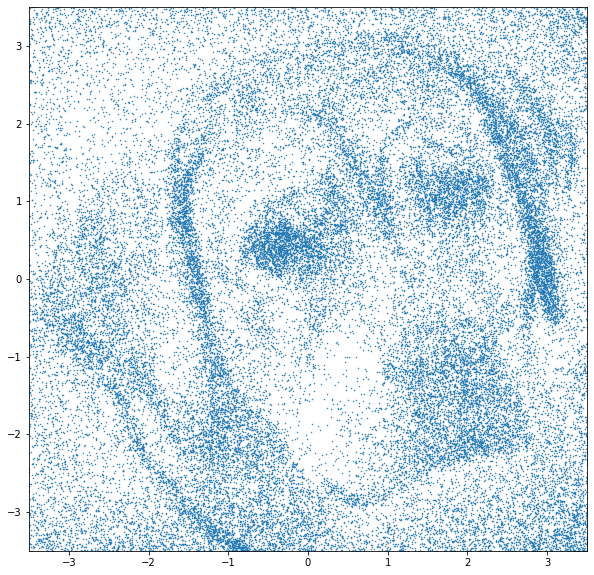

In [38]:
z, x, _ = model_SNF.sample(50000)
plt.figure(figsize=(10, 10))
plt.plot(x[:, 0], x[:, 1], linewidth=0, marker='.', markersize=1)
plt.xlim(-3.5, 3.5)
plt.ylim(-3.5, 3.5)

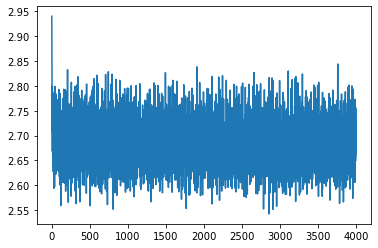

In [39]:
plt.plot(losses)